# Lab 4. Image Analysis

Images are provided with 



Use the thermal and multispectral data shared with you to develop/report the following: 

a. Boxplot showing the temperature data with respect to varieties and treatment, with clear figure title/caption and x-and y-axis labelled, with proper tick marks. (3 ) 

b. Boxplot showing the GNDVI data with respect to varieties and treatment, with clear figure title/caption and x-and y-axis labelled, with proper tick marks. (3 ) 

c.   Add discussion of 125-200 words discussing the data alongside some background information from literature and reference citations. (5 + 2)

In [1]:
%load_ext blackcellmagic
%matplotlib inline
import cv2 as cv
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.imageprocessing import ImageProcessing
from src.roi import PlotCoordinates
import itertools
import string
import matplotlib.lines as lines
from sklearn import linear_model
from matplotlib import patches
import seaborn as sns

In [2]:
def stylize_axes(ax, title="", xlabel="", ylabel="", xticks=[], yticks=[], xticklabels=[], yticklabels=[]):
    """Customize axes spines, title, labels, ticks, and ticklabels."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top='off', direction='out', width=1)
    ax.yaxis.set_tick_params(right='off', direction='out', width=1)
    
    ax.set_title(title)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

def create_imshow_subplots(nrows: int, ncols: int, figsize: tuple, img_list: list, exportname: str):      
    # Create figure
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor="white")

    # Show the image data in subplots
    ax = ax.flatten()

    for i, a in enumerate(ax):
        stylize_axes(a)
        a.text(60, 300, string.ascii_lowercase[i], size=15, weight="bold", color="white")
        masked_img = img_list[i] * masks[i]
        a.imshow(masked_img, interpolation='none', cmap="gray")

    plt.savefig(f"{exportname}.png")
    plt.tight_layout()
    plt.show()


In [3]:
improc = ImageProcessing()
pc = PlotCoordinates()

# import the images
# WT, ABAL, and OST22D Drought and Control
# ['data\\raw\\ABAL_Control.JPG', 'data\\raw\\ABAL_Drought.JPG', 'data\\raw\\OST22D_Control.JPG', 'data\\raw\\OST22D_Drought.JPG', 'data\\raw\\WT-Control.JPG', 'data\\raw\\WT_Drought.JPG']
# y, x, z
imagepaths =  list(pathlib.Path('./data/raw/').glob('*.JPG'))
images = [cv.imread(str(imagepath), cv.IMREAD_UNCHANGED)[900:2800, 1250:4500, :] for imagepath in imagepaths]    
print(images[0].shape)

# (NIR, G, B) order
images_ngb = [cv.cvtColor(image, cv.COLOR_BGR2RGB) for image in images]

# # hsv images
# images_hsv = [cv.cvtColor(image, cv.COLOR_BGR2HSV) for image in images]

# grayscale images
images_grayscale = [cv.cvtColor(image, cv.COLOR_BGR2GRAY) for image in images]

print(imagepaths)
type_dict = {0:{"gt": "ABAL", "treatment":"control"},
             1:{"gt": "ABAL", "treatment":"drought"},
             2:{"gt": "OST22D", "treatment":"control"},
             3:{"gt": "OST22D", "treatment":"drought"},
             4:{"gt": "WT", "treatment":"control"},
             5:{"gt": "WT", "treatment":"drought"},
            }

(1900, 3250, 3)
[WindowsPath('data/raw/ABAL_Control.JPG'), WindowsPath('data/raw/ABAL_Drought.JPG'), WindowsPath('data/raw/OST22D_Control.JPG'), WindowsPath('data/raw/OST22D_Drought.JPG'), WindowsPath('data/raw/WT-Control.JPG'), WindowsPath('data/raw/WT_Drought.JPG')]


(1900, 3250, 3)
255.0 255.0 255.0
(1900, 3250, 3)
255.0 255.0 255.0
(1900, 3250, 3)
255.0 255.0 255.0
(1900, 3250, 3)
255.0 255.0 255.0
(1900, 3250, 3)
255.0 255.0 255.0
(1900, 3250, 3)
255.0 255.0 255.0


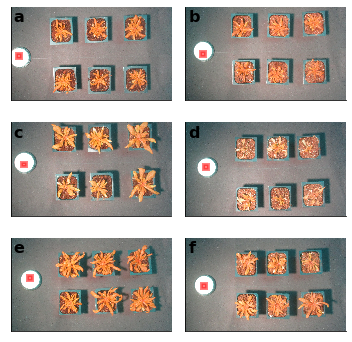

In [4]:
def calibration(
    img_list: list, coord_list: list, figsize: tuple, panel_size: tuple = (50, 50)
):
    """ calculates the correction factor given the region of the reflectance panel """
    # Create figure
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=figsize, facecolor="white")
    
    # Show the image data in subplots
    ax = ax.flatten()

    for i, a in enumerate(ax):
        y, x = coord_list[i]
        height, width = panel_size
        img = img_list[i]
        stylize_axes(a)

        plot_boundary = patches.Rectangle(
            xy=(x, y),
            width=width,
            height=height,
            edgecolor="r",
            lw=3,
            facecolor="r",
            alpha=0.5,
        )
        a.add_patch(plot_boundary)
        a.text(
            60, 300, string.ascii_lowercase[i], size=16, weight="bold", color="black"
        )
        a.imshow(img, interpolation="none", cmap="gray")

        # calculate band values
        print(img.shape)
        nir_mean = np.mean(img[y:y+height, x:x+width, 0])
        g_mean = np.mean(img[y:y+height, x:x+width, 1])
        b_mean = np.mean(img[y:y+height, x:x+width, 2])
        print(nir_mean, g_mean, b_mean)

    plt.savefig("calibration.png")
    plt.tight_layout()
    plt.show()

coord_list = [
    (950, 100),
    (900, 300),
    (800, 200),
    (850, 350),
    (750, 325),
    (925, 325),
]
calibration(images_ngb, coord_list, figsize=(5, 5), panel_size=(100, 100))

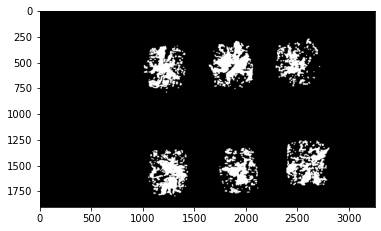

In [5]:
# segment image from background using hsv colorspace
# explore hsv space

def create_mask(img):
    """ takes an rgb image, converts it to hsv, creates and returns mask"""
    image = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    sat = (50, 255)
    val = (100, 255)

    # NIR mask upper hue range
    lower_nir1 = np.array([9, sat[0], val[0]])
    higher_nir1 = np.array([22, sat[1], val[1]])
    mask1 = cv.inRange(image, lower_nir1, higher_nir1)

    # NIR mask lower hue range
    lower_nir2 = np.array([180, sat[0], val[0]])
    higher_nir2 = np.array([180, sat[1], val[1]])
    mask2 = cv.inRange(image, lower_nir2, higher_nir2)

    # segment out the background, close enough
    # seg_img = cv.bitwise_and(image, image, mask=(mask1 + mask2))
    # seg_img_nbg = cv.cvtColor(cv.cvtColor(seg_img, cv.COLOR_HSV2BGR), cv.COLOR_BGR2RGB)
    
    mask = mask1 + mask2

    kernel = np.ones((5, 5), np.uint8)
    mask_morph = mask.copy()
    
    mask_morph = cv.erode(mask_morph, kernel, iterations=2)
    mask_morph = cv.dilate(mask_morph, kernel, iterations=2)
    # mask_morph = cv.erode(mask_morph, kernel, iterations=1)
    # mask_morph = cv.morphologyEx(mask_morph, cv.MORPH_CLOSE, kernel)
    # mask_morph = cv.morphologyEx(mask_morph, cv.MORPH_OPEN, kernel)
    
    mask_bool = np.where(mask_morph > 0, True, False)

    return mask_bool

masks = [create_mask(image) for image in images_ngb]


plt.imshow(masks[3], cmap='gray')
# plt.imshow(images_ngb[1][:,:,0])


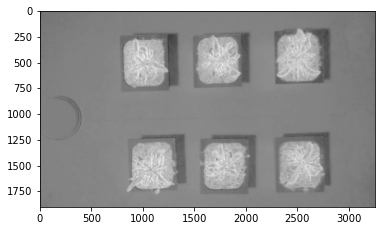

In [6]:
# calculate gndvi 
gndvi_imgs = [improc.calc_spec_idx(combo=(0, 2), bands=img) for img in images_ngb]
plt.imshow(gndvi_imgs[0], cmap="gray")


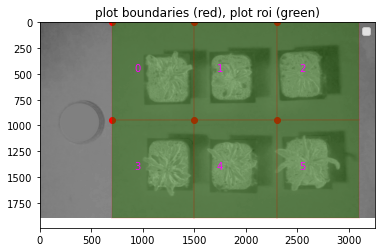

In [7]:
# calculate mean GNDVI for each plant
df = pd.DataFrame({"gt": [], "treatment": [], "mean_GNDVI": []})

half_y = int(.5 * (gndvi_imgs[0].shape[0]))

roi_coords = list(itertools.product([0, half_y], [700, 1500, 2300]))

roi_shape = (half_y, 800)


plot_id_list = pc.plot_boundaries(
    img=gndvi_imgs[5],
    plot_coords=roi_coords,
    roi_coords=roi_coords,
    plot_shape=roi_shape,
    roi_shape=roi_shape,
)

gndvi_means = np.stack([
    [improc.ndsi_mean(arr=gndvi_img, origin=origin, shape=roi_shape, mask=mask) for origin in roi_coords] for gndvi_img, mask in zip(gndvi_imgs, masks)
])



In [8]:
# thermal images

In [9]:
#Boxplot showing the GNDVI data with respect to varieties and treatment, 
# with clear figure title/caption and x-and y-axis labelled, with proper tick marks. (3)
df = pd.DataFrame({"gt": ["aba1-6", "aba1-6", "ost2-2D", "ost2-2D", "WT", "WT"],  "treatment": ["control", "drought","control", "drought","control", "drought"]})

df2 = pd.DataFrame(gndvi_means)
gndvi_df = pd.concat([df, df2], axis=1)
gndvi_df = gndvi_df.melt(id_vars=["gt", "treatment"],var_name="pos_id", value_name="GNDVI_mean")
gndvi_df.to_csv("gndvi_mean.csv")
print(gndvi_df.head())

#create_imshow_subplots(nrows=3, ncols=2, figsize=(8, 8), img_list=gndvi_imgs, exportname="gndvi_fig2")

        gt treatment pos_id  GNDVI_mean
0   aba1-6   control      0    0.529112
1   aba1-6   drought      0    0.472980
2  ost2-2D   control      0    0.459869
3  ost2-2D   drought      0    0.332478
4       WT   control      0    0.517260


a. Boxplot showing the temperature data with respect to varieties and treatment, with clear figure title/caption and x-and y-axis labelled, with proper tick marks. (3 ) 

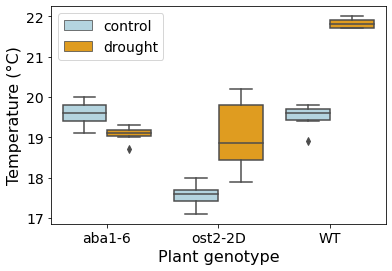

In [10]:
# boxplot for thermal readings
tdf = pd.read_csv("thermal.csv")
#WT, aba1-6, and ost2-2D
sns.boxplot(x = tdf['gt'], y=tdf['temp_C'], hue=tdf['treatment'], palette=["lightblue", "orange"])
plt.ylabel("Temperature (°C)", size=16)
plt.xlabel("Plant genotype", size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(prop={"size":14})
plt.savefig("boxplot_thermal.png")

b. Boxplot showing the GNDVI data with respect to varieties and treatment, with clear figure title/caption and x-and y-axis labelled, with proper tick marks. (3 ) 

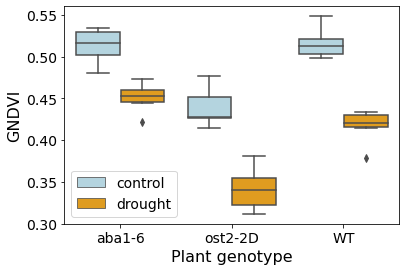

In [11]:
# boxplot for GNDVI
sns.boxplot(x = gndvi_df['gt'], y=gndvi_df['GNDVI_mean'], hue=gndvi_df['treatment'], palette=["lightblue", "orange"])
plt.ylabel("GNDVI", size=16)
plt.xlabel("Plant genotype", size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(prop={"size":14})
plt.savefig("boxplot_gndvi.png")

c.   Add discussion of 125-200 words discussing the data alongside some background information from literature and reference citations. (5 + 2)




c. Steps showing the computation of the parameters listed above. (9)
d. Add discussion of 125-200 words discussing the data alongside some background information from literature and reference citations. (5 + 2)

# Blackbody calibration data 
## 1. Use the blackbody calibration data to estimate the following as discussed in Topic #1, assuming that the overall range of the system is 15ºC to 40ºC:<br> 
- accuracy limit, <br>
- non-linearity, and <br>
- repeatability errors <br>

### a. Include tables with clear table title/caption and column titles of raw and deviation data. (4, 2 each)
 repeatibility error is +-0.02%
 *** accuracy = +-2.4%
 *** nonlinearity: -0.1, or 1% of span

In [12]:
def create_dev_df(df):
    up_df = df.query('direction == "up"').groupby("temp_C").mean().reset_index().rename(columns={'deviation': 'avg_up'})

    # # average of down readings for each value
    down_df = df.query('direction == "down"').groupby("temp_C").mean().reset_index().rename(columns={'deviation': 'avg_down'})

    # # average of up/down readings for each value
    updown_df = df.groupby("temp_C").mean().reset_index().rename(columns={'deviation': 'avg_updown'})

    # merge the df together
    df["avg_up"] = up_df.avg_up
    df["avg_down"] = down_df.avg_down
    df["avg_updown"] = updown_df.avg_updown
    
    return df

# average of up readings for each value
def dev_stats(df, dev_df):
    # min/max deviation
    min_dev = round(dev_df.iloc[:,1:].min().min(), 2)
    max_dev = round(dev_df.iloc[:,1:].max().max(), 2)
    
    range = round(max_dev - min_dev, 2)
    span = 40 - 15
    plus_acc = (max_dev / span)
    min_acc = (round(min_dev / span, 3))
           
    print("deviation stats:")

    # accuracy limit
    print(f"% output span: (+{max_dev} °C or {min_dev}; wrt span of measure)")
    print(f"range: {range}")
    print(f"span: {span}")
    print(f"*** accuracy = +{plus_acc}% and {min_acc}% of output span")
    
    # non-linearity
    nonlin_up = df.query('direction == "up"').query('temp_C == 40').deviation
    nonlin_down = df.query('direction == "down"').query('temp_C == 15').deviation
    nonlin_y = (nonlin_down, nonlin_up)
    nonlin_x = (15, 40)
    print(f"*** nonlinearity: {nonlin_y}")
    wtf = (max_dev + min_dev) * 100 / span
    print(wtf)

    # repeatability
    #maximum variation of successive measurements for the same input value from same direction
    # % of output span
    # random error
    # maximum variation = 0.15 at 1 lb, 0.17 * 100 / 6.45 = 2.6% (+-1.3%)
    
    
    return {"nonlin": (nonlin_y, nonlin_x), "span": span, "range": range, "dev": (min_dev, max_dev), "accuracy": (plus_acc, min_acc)}

def create_deviation_plot(df_list, stats, y_limits:list, figsize:tuple, label_loc:tuple):
    # create the deviation plot
    fig, ax = plt.subplots(nrows=1, ncols=len(df_list), figsize=figsize, facecolor="white")
    fig_letter_x, fig_letter_y = label_loc
    
    for i, df in enumerate(df_list):    
        nonlin_y, nonlin_x = stats[i].get("nonlin")
        min_dev, max_dev = stats[i].get("dev")
        ax[i].set_ylim(y_limits)   
        ax[i].scatter(df["temp_C"], df["avg_up"], color= "orange", facecolors='none', label="mean up", marker='s')
        ax[i].scatter(df["temp_C"], df["avg_updown"], color = 'black', label="mean up/down")
        ax[i].scatter(df["temp_C"], df["avg_down"], color= "blue", facecolors='none', label="mean down", marker='s')
        ax[i].plot([14,41], [0,0], color="black", linewidth=0.75)
        ax[i].plot(nonlin_x, nonlin_y, color="black", linewidth=2, label="non-linearity")
        ax[i].plot([14,41], [min_dev,min_dev], '-.', color="black", linewidth=0.5, label="accuracy limits")
        ax[i].plot([14,41], [max_dev,max_dev], '-.', color="black", linewidth=0.5)
        
        ax[i].set_ylabel('Average deviation (°C)', size=16)
        ax[i].set_xlabel('True temperature (°C)', size=16)
        ax[i].legend(bbox_to_anchor=(.9, 0.3), loc='upper right', ncol=1)
        ax[i].text(fig_letter_x, fig_letter_y, string.ascii_lowercase[i], size=20, weight="bold", color="black")

    fig.tight_layout(pad=3.0)
    
    plt.show()


In [13]:
# import data 
df_base = pd.read_csv("101821_lab4_FLIRcalibration.csv", skiprows=3)
df_base = df_base[["direction", "temp_C", "cycle_1", "cycle_2"]]
df_base = df_base.rename(columns={'cycle_1': '1', 'cycle_2':'2'})

df_base = pd.melt(df_base, id_vars = ['temp_C', 'direction'], value_vars=list(df_base.columns)[2:],
var_name="cycle", value_name='reading')

print(df_base.shape)
print(df_base.head())

#### Ridge regression model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

# pandas to a numpy array
data = df_base.values

# reshape, add a dimension so it works in the model
X, y = data[:, 0].reshape(-1, 1), data[:,-1].reshape(-1, 1)

# define Ridge regression linear model
lm = Ridge(alpha=1.0)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = np.absolute(cross_val_score(lm, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=1))
print(f"Mean MAE: {np.mean(scores)} ({np.std(scores)})")

# fit model
lm.fit(X, y)

# predictions
y_pred = lm.predict(X)
print(f"coeff: {lm.coef_}, intercept: {lm.intercept_}")

# add to dataframe
best_fit = pd.DataFrame({"temp_C":X.flatten(), "best_fit": y_pred.flatten()})


# join column from best_fit into df
df = df_base
df["best_fit"] = best_fit.best_fit
print(f"df_base + base_fit = {df.shape}\n{df.head()}")

# create deviation
# calculate deviation by subtracting the line value from the reading values for ALL data
df["deviation"] = df.reading - df.best_fit
#dev_df = create_dev_df(df)
print(df.head())

(22, 4)
   temp_C direction cycle  reading
0    15.0        up     1     17.2
1    20.0        up     1     21.9
2    25.0        up     1     26.7
3    30.0        up     1     30.6
4    35.0        up     1     35.2
Mean MAE: 0.2607157790402991 (0.13359256885516183)
coeff: [[0.929824]], intercept: [2.58191284]
df_base + base_fit = (22, 5)
   temp_C direction cycle  reading   best_fit
0    15.0        up     1     17.2  16.529273
1    20.0        up     1     21.9  21.178393
2    25.0        up     1     26.7  25.827513
3    30.0        up     1     30.6  30.476633
4    35.0        up     1     35.2  35.125753
   temp_C direction cycle  reading   best_fit  deviation
0    15.0        up     1     17.2  16.529273   0.670727
1    20.0        up     1     21.9  21.178393   0.721607
2    25.0        up     1     26.7  25.827513   0.872487
3    30.0        up     1     30.6  30.476633   0.123367
4    35.0        up     1     35.2  35.125753   0.074247


In [23]:
temp1 = df.query('direction == "up"').groupby("temp_C").mean().reset_index().rename(columns={'deviation': 'avg_up'})
temp2 = df.query('direction == "down"').groupby("temp_C").mean().reset_index().rename(columns={'deviation': 'avg_down'})
temp3 = df.groupby("temp_C").mean().reset_index().rename(columns={'deviation': 'avg_updown'})
dev_df = df.copy()
dev_df.head()
dev_df["avg_up"] = temp1.avg_up
dev_df["avg_down"] = temp2.avg_down
dev_df["avg_updown"] = temp3.avg_updown
    # # # average of down readings for each value
    # down_df = df.query('direction == "down"').groupby("temp_C").mean().reset_index().rename(columns={'deviation': 'avg_down'})

    # # # average of up/down readings for each value
    # updown_df = df.groupby("temp_C").mean().reset_index().rename(columns={'deviation': 'avg_updown'})

    # # merge the df together
    # df["avg_up"] = up_df.avg_up
    # df["avg_down"] = down_df.avg_down
    # df["avg_updown"] = updown_df.avg_updown
    
    # return df
print(dev_df)
print(-0.229273 + 0.075127)
print((40 + 0.87) -(15 + -0.33))

    temp_C direction cycle  reading   best_fit  deviation    avg_up  avg_down  \
0     15.0        up     1     17.2  16.529273   0.670727  0.220727 -0.229273   
1     20.0        up     1     21.9  21.178393   0.721607  0.271607 -0.278393   
2     25.0        up     1     26.7  25.827513   0.872487  0.372487 -0.277513   
3     30.0        up     1     30.6  30.476633   0.123367  0.023367 -0.176633   
4     35.0        up     1     35.2  35.125753   0.074247  0.024247 -0.025753   
5     40.0        up     1     39.9  39.774873   0.125127  0.075127       NaN   
6     35.0      down     1     35.1  35.125753  -0.025753       NaN       NaN   
7     30.0      down     1     30.3  30.476633  -0.176633       NaN       NaN   
8     25.0      down     1     25.5  25.827513  -0.327513       NaN       NaN   
9     20.0      down     1     20.9  21.178393  -0.278393       NaN       NaN   
10    15.0      down     1     16.3  16.529273  -0.229273       NaN       NaN   
11    15.0        up     2  

In [20]:
# Approach 1: ONE deviation plot alongside a calibration plot

# calculate deviation plot stats

# # min/max deviation
min_dev = round(dev_df.deviation.min().min(), 2)
max_dev = round(dev_df.deviation.max().max(), 2)

range = round(max_dev - min_dev, 2)
span = 40 - 15
plus_acc = (max_dev / span)
min_acc = (round(min_dev / span, 3))
        
print("deviation stats:")

# accuracy limit
print(f"% output span: (+{max_dev} °C or {min_dev}; wrt span of measure)")
print(f"range: {range}")
print(f"span: {span}")
accuracy = ((max_dev - min_dev) / span * 100)
print(f"*** accuracy = +-{accuracy/2}%")

# non-linearity

nonlin_up = dev_df.query('direction == "up"').query('temp_C == 40').query('avg_up > 0')
nonlin_down = dev_df.query('direction == "down"').query('temp_C == 15')["avg_down"]
nonlin_y = (nonlin_down, nonlin_up)
nonlin_x = (15, 40)


nonlinearity = round(((nonlin_up + nonlin_down) / (40 - 15)), 2)
print(nonlin_y)
print(f"*** nonlinearity:{nonlinearity}, or {nonlinearity * 100}% of span")

# repeatability
#maximum variation of successive measurements for the same input value from same direction
# % of output span
# random error
# maximum variation = 0.15 at 1 lb, 0.17 * 100 / 6.45 = 2.6% (+-1.3%)
print(dev_df)
print(-0.15/(40-15)*100)

deviation stats:
% output span: (+0.87 °C or -0.33; wrt span of measure)
range: 1.2
span: 25
*** accuracy = +-2.4%
(10   NaN
21   NaN
Name: avg_down, dtype: float64,    temp_C direction cycle  reading   best_fit  deviation    avg_up  avg_down  \
5    40.0        up     1     39.9  39.774873   0.125127  0.075127       NaN   

   avg_updown  
5    0.075127  )
*** nonlinearity:   10  21  avg_down  avg_up  avg_updown  best_fit cycle  deviation direction  \
5 NaN NaN       NaN     NaN         NaN       NaN   NaN        NaN       NaN   

   reading  temp_C  
5      NaN     NaN  , or    10  21  avg_down  avg_up  avg_updown  best_fit cycle  deviation direction  \
5 NaN NaN       NaN     NaN         NaN       NaN   NaN        NaN       NaN   

   reading  temp_C  
5      NaN     NaN  % of span
    temp_C direction cycle  reading   best_fit  deviation    avg_up  avg_down  \
0     15.0        up     1     17.2  16.529273   0.670727  0.220727 -0.229273   
1     20.0        up     1     21.9  21.17

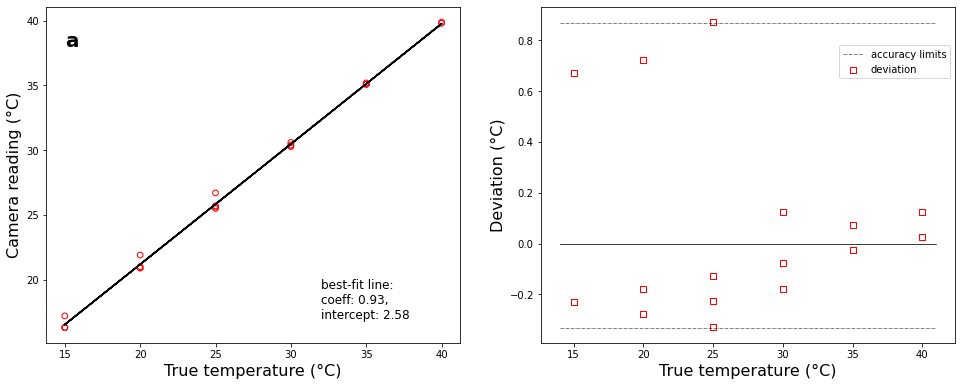

In [26]:
# plot calibration and deviation plots in one figure
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), facecolor="white")
fig_letter_x, fig_letter_y = (13, .85)

# plot calibration curve with best fit line
ax[0].scatter(dev_df.temp_C, dev_df.reading, marker='8', color='red', facecolors='none')
ax[0].set_ylabel('Camera reading (°C)', size=16)
ax[0].set_xlabel('True temperature (°C)', size=16)
ax[0].plot(dev_df.temp_C, dev_df.best_fit, color = "black")
ax[0].annotate(text=(f"best-fit line:\ncoeff: {round(float(lm.coef_),2)}, \nintercept: {round(float(lm.intercept_),2)}"), xy=(32,17), size=12)
ax[0].annotate(text=("a"), xy=(15,38), size=20, weight="bold")
# ax[1].text(fig_letter_x, fig_letter_y, "b", size=20, weight="bold", color="black")

# and now for the deviation plot
# ax[1].set_ylim(-1, 1)   
# ax[1].scatter(dev_df["temp_C"], dev_df["avg_up"], color= "orange", facecolors='none', label="mean up", marker='s')
# ax[1].scatter(dev_df["temp_C"], dev_df["avg_updown"], color = 'black', label="mean up/down")
# ax[1].scatter(dev_df["temp_C"], dev_df["avg_down"], color= "blue", facecolors='none', label="mean down", marker='s')
ax[1].scatter(dev_df["temp_C"], dev_df["deviation"], color= "red", facecolors='none', label="deviation", marker='s')
ax[1].plot([14,41], [0,0], color="black", linewidth=0.75)
# ax[1].plot(nonlin_x, nonlin_y, color="black", linewidth=2, label="non-linearity")
ax[1].plot([14,41], [min_dev,min_dev], '-.', color="black", linewidth=0.5, label="accuracy limits")
ax[1].plot([14,41], [max_dev,max_dev], '-.', color="black", linewidth=0.5)

ax[1].set_ylabel('Deviation (°C)', size=16)
ax[1].set_xlabel('True temperature (°C)', size=16)
ax[1].legend(bbox_to_anchor=(1, .9), loc='upper right', ncol=1)
ax[1].text(fig_letter_x, fig_letter_y, "", size=20, weight="bold", color="black")




fig.tight_layout(pad=3.0)
    
plt.show()

[15. 20. 25. 30. 35. 40. 35. 30. 25. 20. 15.] [ 0.9  0.9  1.   0.2  0.1  0.1  0.   0.  -0.1  0.   0. ]
repeatability error % is +-2.0%


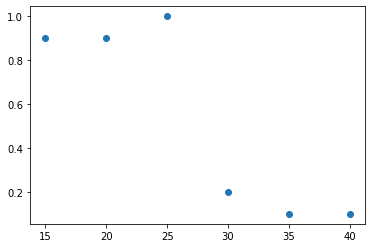

In [25]:
# TWO deviation plots
repeatability = dev_df.query('cycle == "1"')["reading"].values - dev_df.query('cycle == "2"')["reading"].values

temp_C = dev_df.query('cycle == "1"')["temp_C"].values

print(temp_C, repeatability)

t1 = [15, 20, 25, 30, 35, 40]
r1 = [0.9, 0.9, 1, 0.2, 0.1, 0.1]
max_r = np.max(r1)
r_pct = np.max(r1) / (40 - 15) * 100
print(f"repeatability error % is +-{r_pct/2}%")

rdf = pd.DataFrame({"temp_C": t1, "repeat_err": r1})
plt.scatter(rdf.temp_C, rdf.repeat_err)
plt.show()


In [ ]:

# df1.to_csv("cycle_1.csv")
# df2.to_csv("cycle_2.csv")

# dev_list = [create_dev_df(df1), create_dev_df(df2)]
# stats = [dev_stats(df1, dev_list[0]), dev_stats(df2, dev_list[1])]
# create_deviation_plot(dev_list, stats, y_limits=[-1, 1], figsize=(14,6), label_loc=(13, .85))


In [ ]:
# # create figure with deviation plot and calibration plot
# def create_deviation_plot(df_list, stats, y_limits:list, figsize:tuple, label_loc:tuple):
#     # create the deviation plot
#     fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, facecolor="white")
#     fig_letter_x, fig_letter_y = label_loc
    
#     for i, df in enumerate(df_list):    
#         nonlin_y, nonlin_x = stats[i].get("nonlin")
#         min_dev, max_dev = stats[i].get("dev")
#         ax[i].set_ylim(y_limits)   
#         ax[i].scatter(df["temp_C"], df["avg_up"], color= "orange", facecolors='none', label="mean up", marker='s')
#         ax[i].scatter(df["temp_C"], df["avg_updown"], color = 'black', label="mean up/down")
#         ax[i].scatter(df["temp_C"], df["avg_down"], color= "blue", facecolors='none', label="mean down", marker='s')
#         ax[i].plot([14,41], [0,0], color="black", linewidth=0.75)
#         ax[i].plot(nonlin_x, nonlin_y, color="black", linewidth=2, label="non-linearity")
#         ax[i].plot([14,41], [min_dev,min_dev], '-.', color="black", linewidth=0.5, label="accuracy limits")
#         ax[i].plot([14,41], [max_dev,max_dev], '-.', color="black", linewidth=0.5)
        
#         ax[i].set_ylabel('Average deviation (°C)', size=16)
#         ax[i].set_xlabel('True temperature (°C)', size=16)
#         ax[i].legend(bbox_to_anchor=(.9, 0.3), loc='upper right', ncol=1)
#         ax[i].text(fig_letter_x, fig_letter_y, string.ascii_lowercase[i], size=20, weight="bold", color="black")

#     fig.tight_layout(pad=3.0)
    
#     plt.show()
